In [1]:
%matplotlib inline

In [2]:
from galsize_models.models.load_baseline_catalogs import load_umachine_mock
mock = load_umachine_mock()
print(mock.keys())

Total runtime = 39.67 seconds
['obs_sfr', 'icl', 'upid', 'mpeak', 'sfr', 'halo_id', 'mvir', 'rvir', 'vmax_at_mpeak', 'vx', 'a_first_infall', 'sm', 'vy', 'y', 'x', 'vz', 'z', 'dvmax_zscore', 'obs_sm', 'halo_hostid', 'host_halo_rvir', 'host_halo_mvir', 'ssfr', 'is_main_sequence', 'is_green_valley', 'is_quenched', 'logsm', 'rvir_halo_kpc', 'spin_at_infall', 'bt_meert15_random']


In [3]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete, good_profile_mask = load_umachine_sdss_with_meert15()

sdss = full_sdss[behroozi_complete & good_profile_mask]
print(sdss.keys())

disk_dominated_mask = sdss['bulge_to_total_rband_meert15'] < 0.25
bulge_dominated_mask = sdss['bulge_to_total_rband_meert15'] > 0.75
mixed_morphology_mask = ~disk_dominated_mask & ~bulge_dominated_mask


['ra', 'dec', 'z', 'bptclass', 'sm', 'sfr', 'specsfr', 'sm_fib', 'sfr_fib', 'specsfr_fib', 'withinr', 'eligiblehost', 'sm_complete', 'eligiblehost2', 'd4000', 'd4000_sub', 'd4000_n', 'd4000_n_sub', 'has_match', 'logM_mendel13', 'logMB_mendel13', 'logMD_mendel13', 'pps_mendel13', 'type_mendel13', 'deltaBD_mendel13', 'dr7_objID', 'has_meert15_match', 'r50_magr_kpc_meert15', 'Magr_tot_meert15', 'Magr_bulge_meert15', 'Magr_disk_meert15', 'gr_bulge_meert15', 'gr_disk_meert15', 'morph_type_T_meert15', 'gr_kcorr_meert15', 'bulge_to_total_rband_meert15', 'ssfr']


In [4]:
from galsize_models.models.bulge_disk_double_power_law import galaxy_size_vs_rhalo

norm_bulge = 0.002
bulge_to_disk_size_ratio = 1/7.
alpha_bulge = 1.25
alpha_disk = 1
scatter = 0.15

norm_disk = norm_bulge/bulge_to_disk_size_ratio

rvir_halo_kpc = mock['rvir_halo_kpc']
bt = mock['bt_meert15_random']
mock['r50_magr_kpc_meert15'] = galaxy_size_vs_rhalo(rvir_halo_kpc, bt, 
                    norm_bulge, norm_disk, 
                     alpha_bulge, alpha_disk, scatter=scatter)


bulge_dominated_mask_mock = mock['bt_meert15_random'] > 0.75
disk_dominated_mask_mock = mock['bt_meert15_random'] < 0.25
mixed_morphology_mask_mock = ~disk_dominated_mask_mock & ~bulge_dominated_mask_mock


from scipy.stats import binned_statistic
logsm_bins = np.linspace(9.75, 11.5, 25)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
median_rhalf_bulge_mock, __, __ = binned_statistic(
        mock['obs_sm'][bulge_dominated_mask_mock], 
        mock['r50_magr_kpc_meert15'][bulge_dominated_mask_mock], bins=10**logsm_bins)
median_rhalf_disk_mock, __, __ = binned_statistic(
        mock['obs_sm'][disk_dominated_mask_mock], 
        mock['r50_magr_kpc_meert15'][disk_dominated_mask_mock], bins=10**logsm_bins)
median_rhalf_all_mock, __, __ = binned_statistic(
        mock['obs_sm'], mock['r50_magr_kpc_meert15'], bins=10**logsm_bins)
median_rhalf_mixed_mock, __, __ = binned_statistic(
        mock['obs_sm'][mixed_morphology_mask_mock], 
        mock['r50_magr_kpc_meert15'][mixed_morphology_mask_mock], bins=10**logsm_bins)


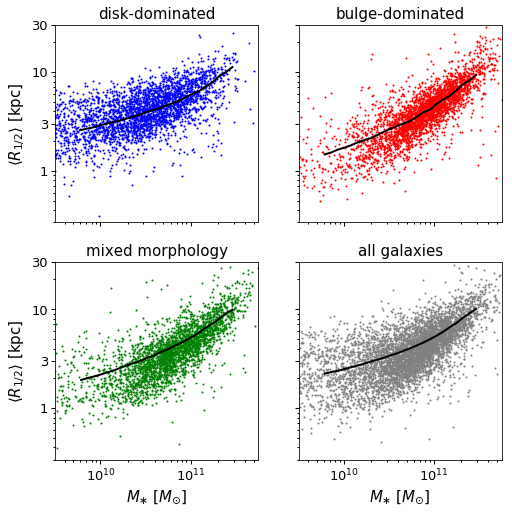

In [5]:
from matplotlib import ticker 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, 
                              figsize=(8, 8))
axes = (ax1, ax2, ax3, ax4)

for ax in axes:
    __=ax.loglog()

__=ax1.scatter(10**sdss['sm'][disk_dominated_mask][::20], 
              sdss['r50_magr_kpc_meert15'][disk_dominated_mask][::20], 
             s=1, color='blue')
__=ax2.scatter(10**sdss['sm'][bulge_dominated_mask][::10], 
              sdss['r50_magr_kpc_meert15'][bulge_dominated_mask][::10], 
             s=1, color='red')
__=ax3.scatter(10**sdss['sm'][mixed_morphology_mask][::40], 
              sdss['r50_magr_kpc_meert15'][mixed_morphology_mask][::40], 
             s=1, color='green')
__=ax4.scatter(10**sdss['sm'][::40], sdss['r50_magr_kpc_meert15'][::40], 
             s=1, color='gray')


__=ax1.plot(10**logsm_mids, median_rhalf_disk_mock, color='k', lw=2)
__=ax2.plot(10**logsm_mids, median_rhalf_bulge_mock, color='k', lw=2)
__=ax3.plot(10**logsm_mids, median_rhalf_mixed_mock, color='k', lw=2)
__=ax4.plot(10**logsm_mids, median_rhalf_all_mock, color='k', lw=2)


xmin, xmax = 10**9.5, 10**11.75
ymin, ymax = 0.3, 30
xlabel = r'$M_{\ast}$ $[M_{\odot}]$'
ylabel = r'$\langle R_{1/2} \rangle$ $[{\rm kpc}]$'
for ax in axes:
    xlim = ax.set_xlim(xmin, xmax)
    ylim = ax.set_ylim(ymin, ymax)
    __=ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    __=ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
    __=ax.set_yticks((1, 3, 10, 30))

ylabel1=ax1.set_ylabel(ylabel)
__=ax3.set_ylabel(ylabel)
xlabel3=ax3.set_xlabel(xlabel)
__=ax4.set_xlabel(xlabel)

title1 = ax1.set_title(r'disk-dominated')
title2 = ax2.set_title(r'bulge-dominated')
title3 = ax3.set_title(r'mixed morphology')
title4 = ax4.set_title(r'all galaxies')

figname = 'size_vs_stellar_mass_multipanel_bt_decomposition.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel1], bbox_inches='tight')
